In [1]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors, NearestCentroid
from tqdm import tqdm
import ast
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statistics

In [2]:
embedding_path = '../data/raw/df_embeddings.csv'
submission_path = '../data/raw/df_submission_rating.csv'


df_embeddings = pd.read_csv(embedding_path)
df_embeddings = df_embeddings.T
df_embeddings.columns=df_embeddings.iloc[0]
df_embeddings = df_embeddings.iloc[1: , :]


tqdm.pandas()
def get_numpy (row):
  return ast.literal_eval(row.embedding)

df_embeddings['embedding'] = df_embeddings.apply(lambda x: get_numpy(x), axis =1)

df_submissions = pd.read_csv(submission_path)
df_submission_labels = df_submissions[['id','title','conf_year','keywords','AVG_rating']]

df_embeddings_2017 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2017], left_on='paper_id',right_on='id')
df_embeddings_2018 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2018], left_on='paper_id',right_on='id')
assert df_submission_labels[df_submission_labels['conf_year']==2017].shape[0] == df_embeddings_2017.shape[0]

In [3]:
#Section 3.3 Step 2 agglomerative clustering on cosine distance
x = np.array(df_embeddings_2017.embedding.tolist())
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, linkage="average", metric = 'cosine').fit(x)
df_embeddings_2017['agg_cluster'] = clustering.labels_.tolist()
x = np.array(df_embeddings_2017.embedding.tolist())
y = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(x, y)

assert df_embeddings_2018.shape[0] == df_submission_labels[df_submission_labels['conf_year']==2018].shape[0]


In [4]:
#Section 3.3. Step 3

#setting up KNN for 2018
neigh = NearestNeighbors( n_neighbors=10, metric = 'cosine', radius = 0.3)
non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
neigh.fit(non_anchor_embedding_2018)

#setting up closest centroid for anchor group 2017
anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)



#dictionary of all the agg clusters and the 10 KNN from 2018
dict_agg_cluster_matches ={}
tuning_param_cos_dist = 0.3
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )


def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')
df_cos_dist_sample = pd.concat([df_embeddings_2017[['agg_cluster']],pd.DataFrame(df_embeddings_2017["cos_dist_2018"].to_list())], axis=1)


#tuning charts
#get the max number of samples with the lowest possible cosine distance
df_tuning = df_cos_dist_sample.drop(['agg_cluster'],axis = 1)

Figure 2


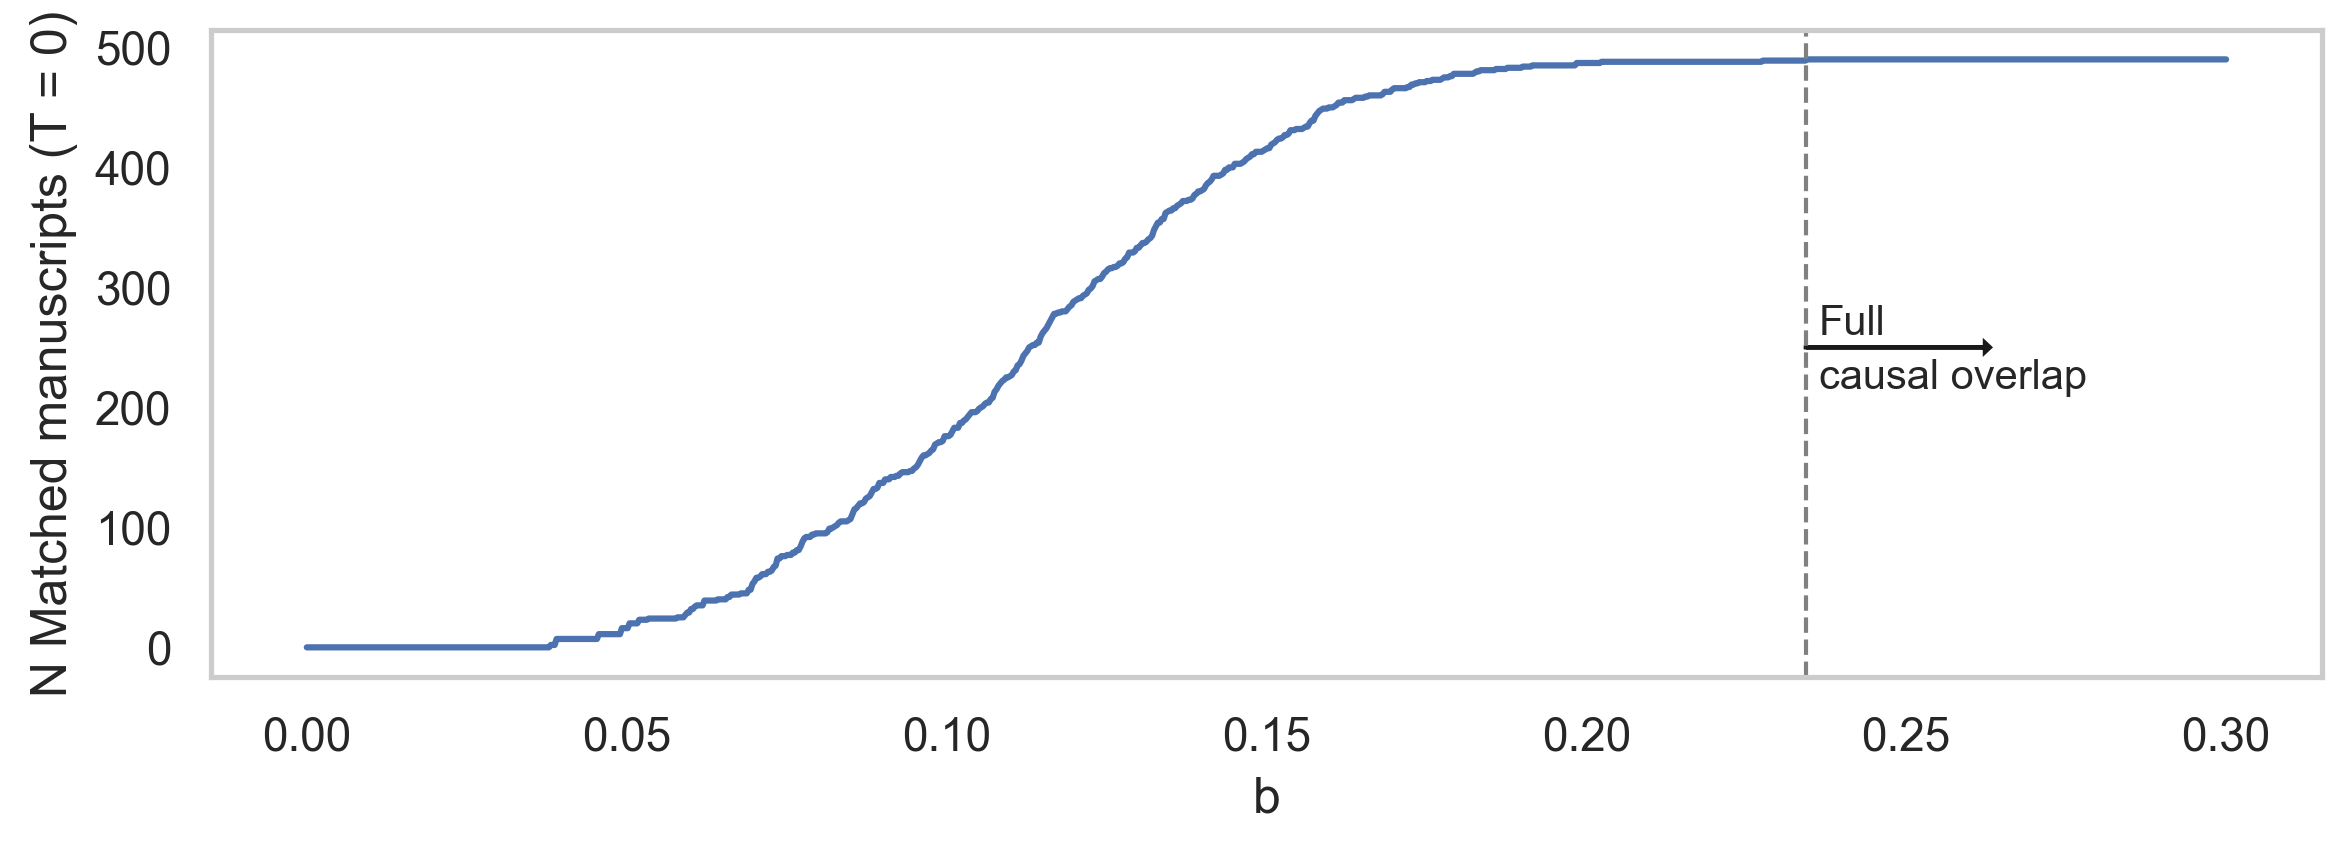

In [5]:


print('Figure 2')
data = []
for tuning_param_cos_dist in np.linspace(0,0.3 ,1000):
    input_row = {}
    sample_number_from_2017 = df_tuning[df_tuning<=tuning_param_cos_dist].any(axis=1).sum()
    
    input_row['sample_number_2017'] = sample_number_from_2017
    input_row['cosine_distance'] = tuning_param_cos_dist
    if sample_number_from_2017 == df_tuning.shape[0]:
        input_row['full_sample_flag'] = 'Full Sample'
    else:
        input_row['full_sample_flag'] = 'Partial Sample'
    data.append(input_row)


x = pd.DataFrame(data)
sns.set(rc={'figure.dpi':300, 'figure.figsize':(8,3)})

sns.set_style("whitegrid")
ax = sns.lineplot(data=x, x='cosine_distance', y='sample_number_2017')
ax.grid(False)
ax.set(ylabel="N Matched manuscripts (T = 0)", xlabel="b")
THRESHOLD = 0.2343
plt.axvline(x=THRESHOLD, ymin=0, ymax=510, linestyle="--", linewidth=1, color='gray')


ax.arrow(THRESHOLD, 250, 0.028,0, head_width=8, head_length=0.0008, fc='k', ec='k')
plt.text(THRESHOLD + 0.002, 260, "Full", fontdict={"size":10})
plt.text(THRESHOLD + 0.002, 215, "causal overlap", fontdict={"size":10})
  
plt.tight_layout()
plt.show()

In [6]:
def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')
df_cos_dist_sample = pd.concat([df_embeddings_2017[['agg_cluster']],pd.DataFrame(df_embeddings_2017["cos_dist_2018"].to_list())], axis=1)

#tuning charts
#get the max number of samples with the lowest possible cosine distance
df_tuning = df_cos_dist_sample.drop(['agg_cluster'],axis = 1)

data = []
for tuning_param_cos_dist in np.linspace(0,0.3 ,1000):
    input_row = {}
    sample_number_from_2017 = df_tuning[df_tuning<=tuning_param_cos_dist].any(axis=1).sum()
    
    input_row['sample_number_2017'] = sample_number_from_2017
    input_row['cosine_distance'] = tuning_param_cos_dist
    if sample_number_from_2017 == df_tuning.shape[0]:
        input_row['full_sample_flag'] = 'Full Sample'
    else:
        input_row['full_sample_flag'] = 'Partial Sample'
    data.append(input_row)


x = pd.DataFrame(data)

#Tune KNN matching based on smallest possible cosine distance

tuning_param_knn = 10
tuning_param_cos_dist = 0.234535

neigh = NearestNeighbors( n_neighbors=tuning_param_knn, metric = 'cosine', radius = 0.3)
non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
neigh.fit(non_anchor_embedding_2018)

#setting up closest centroid for anchor group 2017
anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)


#dictionary of all the agg clusters and the 20 KNN from 2018
dict_agg_cluster_matches ={}
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )

def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances
    
    
    

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')

def get_num_knn_matches(row):
    count = len(row.titles_2018)
    return(len(row.titles_2018))

df_embeddings_2017['num_knn_matches'] = df_embeddings_2017.apply(lambda x: get_num_knn_matches(x),axis =1)

assert df_embeddings_2017.shape[0] == df_submission_labels[df_submission_labels['conf_year']==2017].shape[0]

#Matching potential outcome estimator
#Keith et al. 2020
#https://aclanthology.org/2020.acl-main.474.pdf
#equation 7 and 8

def lambda_get_match_potential_outcomes(row):
    #equation 7 in the paper
    paper_ids = row.id_2018
    big_m = len(row.id_2018)
    if big_m == 0:
        return None
    ratings = [df_embeddings_2018[df_embeddings_2018['paper_id'] == paper_id].AVG_rating.values[0] for paper_id in paper_ids]
    return sum(ratings)/big_m
        
    

df_embeddings_2017['match_ave_rating'] = df_embeddings_2017.apply(lambda row: lambda_get_match_potential_outcomes(row), axis =1)
df_embeddings_2017['diff_2018_2017'] = df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']

df_embeddings_2017 = df_embeddings_2017.loc[df_embeddings_2017['match_ave_rating'].notnull(),]

#equation 8 in the paper
KNN_ATT = (df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']).sum()/df_embeddings_2017.shape[0]

assert df_embeddings_2017['match_ave_rating'].shape[0] == df_embeddings_2017['AVG_rating'].shape[0]

#bootstrap KNN confidence interval
bootstrap_mean = []
for n in range(5000):
    sample = df_embeddings_2017.diff_2018_2017.sample(n=df_embeddings_2017.shape[0], replace = True ,random_state=n)
    bootstrap_mean.append(sample.mean())
    
mean = statistics.mean(bootstrap_mean)
CI_lower_bound_knn = np.quantile(bootstrap_mean, 0.025)
CI_upper_bound_knn = np.quantile(bootstrap_mean, 0.975)
CI_knn_range = abs(CI_lower_bound_knn) -abs(CI_upper_bound_knn)

In [7]:
print(mean, CI_lower_bound_knn, CI_upper_bound_knn, CI_knn_range)

-0.16975167217363135 -0.28714692662779395 -0.04985991658568188 0.23728701004211206


In [8]:
print('Table 3')
#Table 3 in Appendix
first_row = df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','cos_dist_2018','keywords_2018']].iloc[1]
print('2017 title: ',first_row.title,'|')
print('\n')
for title, keywords_2018, cos_dist_2018 in zip(first_row.titles_2018,first_row.keywords_2018, first_row.cos_dist_2018):
    print("2018 title:",title, '| cosine distance',round(cos_dist_2018,3) )
print('-'*100)

print('Table 4')
print(pd.DataFrame(list(itertools.chain.from_iterable(df_embeddings_2017.titles_2018.to_list())),columns=['paper_id']).value_counts().head())
print('-'*100)

Table 3
2017 title:  Machine Comprehension Using Match-LSTM and Answer Pointer |


2018 title: QANet: Combining Local Convolution with Global Self-Attention for Reading Comprehension | cosine distance 0.104
2018 title: Multi-Mention Learning for Reading Comprehension with Neural Cascades | cosine distance 0.11
2018 title: LEARNING TO ORGANIZE KNOWLEDGE WITH N-GRAM MACHINES | cosine distance 0.129
2018 title: FAST READING COMPREHENSION WITH CONVNETS | cosine distance 0.131
2018 title: ElimiNet: A Model for Eliminating Options for Reading Comprehension with Multiple Choice Questions | cosine distance 0.133
2018 title: FusionNet: Fusing via Fully-aware Attention with Application to Machine Comprehension | cosine distance 0.133
2018 title: Dynamic Integration of Background Knowledge in Neural NLU Systems | cosine distance 0.139
2018 title: Neural Compositional Denotational Semantics for Question Answering | cosine distance 0.142
2018 title: Phase Conductor on Multi-layered Attentions for M